# Attribution Analysis for Splice Site Predictions

Compute and visualize input attributions (feature importance) for model predictions using gradient-based methods.

We compute gradients of the loss, so the signs indicate relative importance of input features for model decisions.

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# Setup path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from splicevo.model import SplicevoModel
from splicevo.utils.data_utils import load_processed_data, load_predictions
from splicevo.utils.model_utils import load_model_and_config
from splicevo.attributions import (
    compute_attributions_for_sequence,
    compute_attributions_batch,
    plot_attributions_splice,
    plot_attributions_usage
)

/home/elek/miniforge3/envs/splicevo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration and Data Loading
subset = "middle"
species = "mouse_rat"

checkpoint_path = f"/home/elek/sds/sd17d003/Anamaria/splicevo/models/{subset}_{species}_weighted_mse/best_model.pt"  
data_path = f"/home/elek/sds/sd17d003/Anamaria/splicevo/data/splits_{subset}/{species}/test/"
predictions_path = f"/home/elek/sds/sd17d003/Anamaria/splicevo/predictions/{subset}_{species}_weighted_mse/"
device = 'cuda'

# Load model
model, model_config = load_model_and_config(checkpoint_path, device=device)

# Load data
sequences, labels, _, _, usage, _ = load_processed_data(data_path, verbose=False)
metadata = pd.read_csv(data_path + "metadata.csv")

# Load splice predictions
pred_preds, pred_probs, pred_sse, meta, _, _ = load_predictions(predictions_path, verbose=False)

print(f"Loaded sequences shape: {sequences.shape}")
print(f"Loaded labels shape: {labels.shape}")
print(f"Model output config: {model_config}")

Loaded sequences shape: (9701, 1900, 4)
Loaded labels shape: (9701, 1000)
Model output config: {'embed_dim': 128, 'num_resblocks': 16, 'dilation_strategy': 'alternating', 'alternate': 4, 'num_classes': 3, 'context_len': 450, 'dropout': 0.4, 'n_conditions': 28, 'usage_loss_type': 'weighted_mse'}


## Splice Site Attributions

Calculate attributions for selected sequences. I will only calculate attributions for correctly predicted splice sites

In [4]:
model.set_output_type('splice')

attrs_splice_dict = {}
seq_indices = [1095, 2153, 3093, 3581, 3649, 4076]  # Selected sequences
seq_indices = [0]

attrs_splice_dict, total_skipped, total_calculated = compute_attributions_batch(
    model=model,
    sequences=sequences,
    labels=labels,
    seq_indices=seq_indices,
    usage=None,
    output_type='splice',
    predictions=pred_preds,
    metadata=metadata,
    device=device,
    verbose=False
)

print(f"Computed attributions for {len(attrs_splice_dict)} splice sites.")
print(f"Skipped {total_skipped} sites with incorrect predictions.")
print(f"Total sites calculated: {total_calculated}")

Computed attributions for 1 splice sites.
Skipped 1 sites with incorrect predictions.
Total sites calculated: 1


Create sequence logos showing attribution values for splice sites

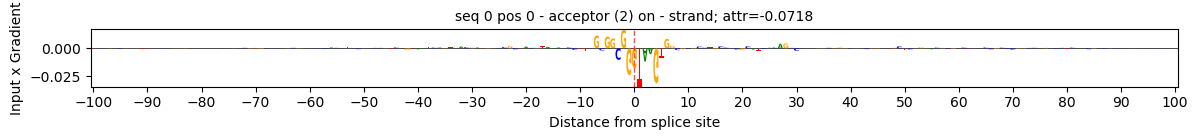

In [6]:
fig = plot_attributions_splice(
    attrs_dict=attrs_splice_dict,
    model_config=model_config,
    max_plots=5,
    window=100,
    figsize=(12, len(seq_indices)*1.5)
)
plt.show()

## Usage (Condition-Specific) Attributions

Calculate attributions for splice sites across different conditions

In [7]:
model.set_output_type('usage')

attrs_usage_dict = {}

# Select range of sequences
sequence_range = 50
seq_indices = list(range(sequence_range))

# Selected sequences by index
seq_indices = [0]

attrs_usage_dict, total_skipped, total_calculated = compute_attributions_batch(
    model=model,
    sequences=sequences,
    labels=labels,
    seq_indices=seq_indices,
    usage=usage,
    output_type='usage',
    predictions=pred_preds,
    metadata=metadata,
    device=device,
    verbose=False
)

print(f"Computed attributions for {len(attrs_usage_dict)} splice sites (usage predictions).")
print(f"Skipped {total_skipped} sites with incorrect splice classification.")
print(f"Total sites calculated: {total_calculated}")

Computed attributions for 1 splice sites (usage predictions).
Skipped 1 sites with incorrect splice classification.
Total sites calculated: 1


Create sequence logos for each condition separately

In [ ]:
conditions = meta.get('conditions', None)

fig = plot_attributions_usage(
    attrs_dict=attrs_usage_dict,
    model_config=model_config,
    conditions=conditions,
    window=50,
    figsize=(12, len(seq_indices)*len(conditions)*1.2)
)
plt.show()